In [2]:
import sys
print sys.path

import psycopg2 as ppg

con = ppg.connect("dbname=tweets user=patrick")
print con

['', '/home/patrick/anaconda/lib/python27.zip', '/home/patrick/anaconda/lib/python2.7', '/home/patrick/anaconda/lib/python2.7/plat-linux2', '/home/patrick/anaconda/lib/python2.7/lib-tk', '/home/patrick/anaconda/lib/python2.7/lib-old', '/home/patrick/anaconda/lib/python2.7/lib-dynload', '/home/patrick/anaconda/lib/python2.7/site-packages', '/home/patrick/anaconda/lib/python2.7/site-packages/Sphinx-1.2.3-py2.7.egg', '/home/patrick/anaconda/lib/python2.7/site-packages/cryptography-0.8-py2.7-linux-x86_64.egg', '/home/patrick/anaconda/lib/python2.7/site-packages/setuptools-17.0-py2.7.egg', '/home/patrick/anaconda/lib/python2.7/site-packages/IPython/extensions']
<connection object at 0x7f95d0a4c7f8; dsn: 'dbname=tweets user=patrick', closed: 0>


In [3]:
#cur = con.cursor()
#cur.execute("SELECT tweet_id FROM tweets;")
#tweet_id = set(zip(*cur.fetchall())[0])
#cur.close()

Populating the interactive namespace from numpy and matplotlib
freq    388504
dtype: int64


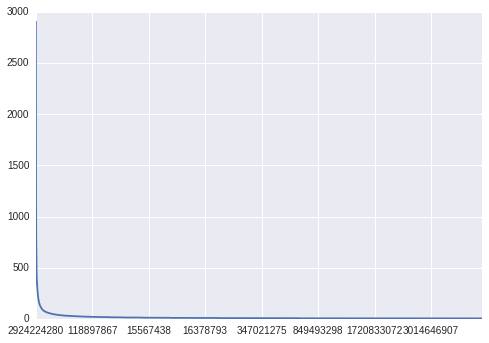

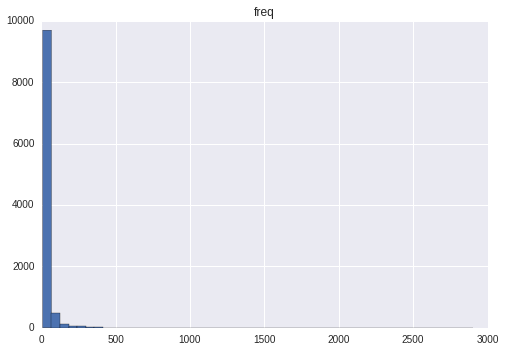

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

with con.cursor() as cur:
    cur.execute("SELECT user_id FROM tweets;")
    users = zip(*cur.fetchall())[0]

user_counts = pd.DataFrame({ 'freq': pd.Series(users).value_counts() })
user_counts[user_counts.freq>3].freq.plot()
user_counts[user_counts.freq>10].hist(bins=50)
print user_counts[user_counts.freq>10].sum()

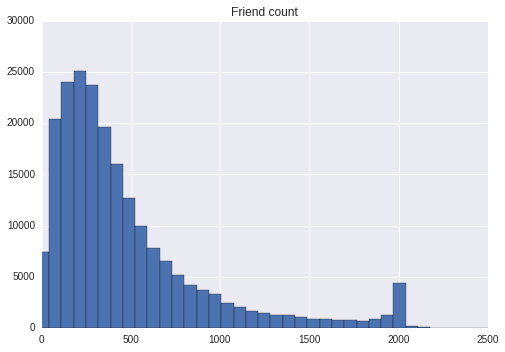

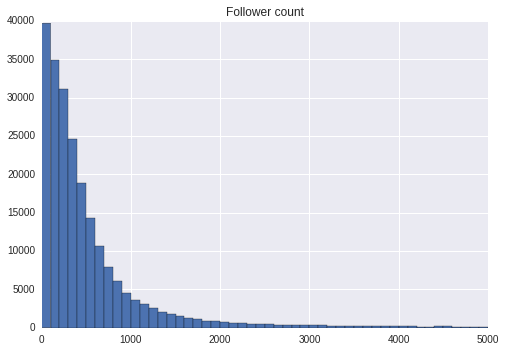

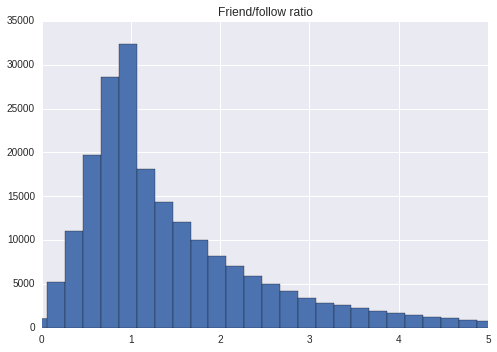

In [5]:
#explore follower count etc. (in original data)
with con.cursor() as cur:
    cur.execute("SELECT user_id, friends_count, followers_count FROM users")
    ffdf = pd.DataFrame(cur.fetchall(), columns=[c[0] for c in cur.description])
    
plt.figure(1)
ffdf[(ffdf.friends_count < 5000) & (ffdf.followers_count < 2000)].friends_count.hist(bins=50)
plt.xlim([0,2500])
plt.title("Friend count")
plt.figure(2)
ffdf[ffdf.followers_count < 5000].followers_count.hist(bins=50)
plt.xlim([0,5000])
plt.title("Follower count")
plt.figure(3)
(ffdf[(ffdf.friends_count < 5000) & (ffdf.followers_count < 2000)].friends_count /
ffdf[(ffdf.friends_count < 5000) & (ffdf.followers_count < 2000)].
       followers_count).replace([np.inf, -np.inf], np.nan).dropna().hist(bins=500)
plt.xlim([0,5])
#plt.ylim([0,2000])
plt.title("Friend/follow ratio")

#import random
#plt.scatter(geotags[geotags['in_us']==True]['tweet_long'],geotags[geotags['in_us']==True]['tweet_lat'],
#           c=(0.9,0.9,0.9,0.5), edgecolor='None')
# random user's home location
#random_user = geotags.loc[random.sample(geotags[geotags.on_road].index, 1), 'user_id']


#user_tweets = geotags[geotags['user_id']==random_user.values[0]]
#print user_tweets
#plt.scatter(user_tweets.tweet_long, user_tweets.tweet_lat,
#            c='red', marker='.', s=100)
#plt.scatter(user_tweets.user_long.drop_duplicates(), user_tweets.user_lat.drop_duplicates(), 
#            c='red', marker='x', linewidth = '3', s=100)


In [6]:
# with con.cursor() as cur:
#     cur.execute("SELECT tweet_id, user_id, in_reply_to_tweet_id FROM tweets")
#     tweets_list = cur.fetchall()
# tweets = pd.DataFrame(tweets_list, columns=['tweet_id','user_id','reply_id']).set_index('tweet_id')
# %timeit replied_to = tweets[tweets.reply_id != 'None'].reply_id.values
# tweet_ids = set(tweets.index)
# %timeit questions = tweets[[twid in replied_to for twid in tweet_ids]]
# print questions

In [7]:
# replies = tweets[tweets.reply_id != 'None']
# hanging_questions= pd.Series([rid for rid in replies.reply_id if rid not in questions.tweet_id.values])
# print hanging_questions

Base rate of @-mentions
Base rate of in-reply-to's
Find variation across users in in-reply-to's/total num. tweets
Ratio by user of outgoing @mention rate to in-reply-to (to all that user's tweets)

In [8]:
# # annotate tweets with initial @mention rate
# at_ment_re = re.compile(r"^\s+\.?@")
# tweets['at_mention'] = tweets.text.apply(lambda x:
#      at_ment_re.search(x) is not None)
                                         

# users_grps = tweets.groupby('user_id')
# users_df = users_grps.apply(lambda x: pd.DataFrame({'num_at_out': x.at_mention.sum(),
#                                                     'num_at_in': 
#reload(seaborn)
con.rollback()

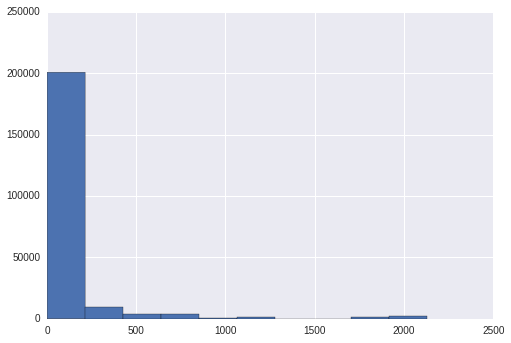

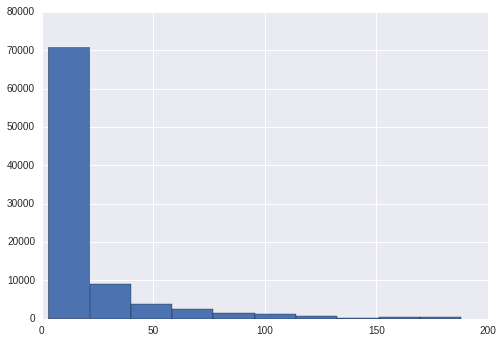

In [16]:
# Explore geotags
usa = (-125.6791025,25.4180700649,-66.885417,
                           49.3284551525)
la = ( -119.578941, 32.799580, -114.130814, 35.809120)
    
def in_place(pts, box, long_field='tweet_long', lat_field='tweet_lat'):
    return pd.Series((pts[long_field] > box[0]) & 
                     (pts[lat_field] > box[1]) &
                     (pts[long_field] < box[2]) &
                     (pts[lat_field] < box[3]))

with con.cursor() as cur:
    cur.execute("SELECT tw.tweet_id, tw.user_id, tw.lat as tweet_lat, tw.long as tweet_long, "
                "tw.created_at, user_locs.followers_count,user_locs.friends_count, "
                "user_locs.place as user_location, plcs.user_lat, "
                "plcs.user_long "
                "FROM tweets as tw, (SELECT user_id, place, friends_count, followers_count "
                "FROM users) as user_locs, "
                "(SELECT place, coded_lat as user_lat, coded_long as user_long FROM "
                "places) as plcs "
                "WHERE tw.user_id = user_locs.user_id "
#                "and plcs.place = user_locs.place AND plcs.user_lat != -500 AND "
#             "plcs.user_long != 500 AND "
                "tw.text !~ '#insurancejobs|#jobs?|#hiring|#tweetmyjobs';")
    
# old location text limits
#(user_locs.place != 'None' AND user_locs.place ~* '[A-Z\s]+,\s*[A-Z]+' OR "
#                "user_locs.place ~* '(New York City|NYC|LA|Los Angeles|Chicago|DC|SF|San Francisco|"
#                "Detroit|Houston|Dallas|Atlanta|Philly|Philadelphia|Phoenix|San Antonio| "
#                "San Jose|Austin|Jacksonville|Indianapolis|Denver)')

    geotags = pd.DataFrame(cur.fetchall(), 
                       columns=[c[0] for c in cur.description])
    
geotags['in_us'] = in_place(geotags[['tweet_long','tweet_lat']], usa)
geotags['in_la'] = in_place(geotags[['tweet_long','tweet_lat']], la)

geotags= geotags.merge(geotags.groupby('user_id').apply(lambda x: pd.Series(x.shape[0], index=['num_tweets_user'])),
                    left_on='user_id', right_index=True, how='left')

plt.figure(1)
geotags.num_tweets_user.hist()

# drop certain users
geotags = geotags[(geotags.followers_count < 2000) & 
                  (geotags.friends_count < 1800) &
                  (geotags.num_tweets_user < geotags.shape[0] / 1000) &
                  (geotags.num_tweets_user >= 3) &
                  (geotags.friends_count / geotags.followers_count >= 0.25)]

# look at distance between user location and tweet location

geotags['tweet_distance'] = np.sqrt((geotags.user_lat - geotags.tweet_lat) ** 2 + 
                                    (geotags.user_long - geotags.tweet_long) ** 2)
geotags['on_road'] = geotags['tweet_distance'] > 0.5

# get number of users w/ any on-road tweets, other per-user stats
users_on_road=geotags.groupby('user_id').apply(lambda x: pd.Series([x.on_road.any(), x.on_road.sum()],
         index=['any_on_road','num_on_road']))
geotags = geotags.merge(users_on_road, left_on='user_id', right_index=True)


plt.figure(2)
geotags.num_tweets_user.hist()


In [17]:
print "Number NA user lat/long: " + str(geotags[['user_id', 'user_lat']].drop_duplicates().user_lat.isnull().sum())
print geotags.shape
geotags.head(10)
print geotags[geotags.in_la].shape

Number NA user lat/long: 0
(91380, 17)
(12247, 17)


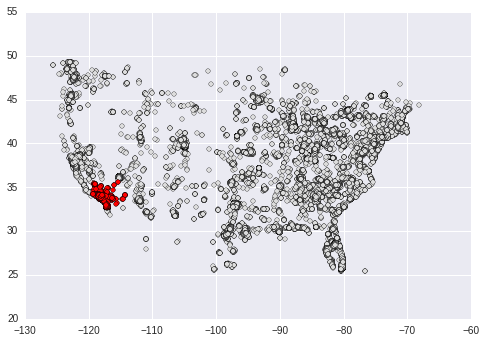

In [10]:
plt.scatter(geotags[geotags['in_us']==True]['tweet_long'], geotags[geotags['in_us']==True]['tweet_lat'], c='#dddddd')
plt.scatter(geotags[geotags['in_la']==True]['tweet_long'], geotags[geotags['in_la']==True]['tweet_lat'], c='red')


#LA

In [11]:
con.rollback()

In [12]:
# get locations for tweets in LA
import re
# get number of distinct users
print "Number of users: ", geotags[geotags.in_la].user_id.drop_duplicates().shape[0]
# their locations
#print geotags[geotags.in_la][['user_id','user_location']].drop_duplicates().user_location
def normalizer(txt):
    txt = txt.strip()
    txt = txt.lower()
    
    txt = re.sub(ur"[,.]", u" ", txt,  re.UNICODE)
    txt = re.sub(ur"\s+", u" ", txt, re.UNICODE)
    txt = re.sub(ur"cali[^\s]+", u"ca", txt, re.UNICODE | re.IGNORECASE)
    return txt
#print geotags[geotags.in_la][['user_id','user_location']].drop_duplicates().user_location.map(normalizer).value_counts().index.tolist()

# get places
with con.cursor() as cur:
    cur.execute("SELECT user_id, place, coded_lat, coded_long FROM users "
                "JOIN (SELECT place, coded_lat, coded_long FROM places) AS places USING (place)")
    places_df = pd.DataFrame(cur.fetchall(), columns = [c[0] for c in cur.description])
places_df['places_norm'] = places_df.place.map(lambda x: x.decode('utf-8')).map(normalizer)
places_df = places_df.merge(pd.DataFrame(geotags[geotags.in_la][['user_id','user_location']]. \
                                         drop_duplicates().user_location.map(lambda x: x.decode('utf-8')).
                                         map(normalizer)),
               left_on='places_norm',right_on='user_location')
#print places_df['coded_long'].map(lambda x: x > la[0] & x < la[1])
places_df['in_la'] = places_df['coded_long'].map(lambda x: (x > la[0]) & (x < la[2])) & \
                     places_df['coded_lat'].map(lambda x: (x > la[1]) & (x < la[3])) | \
                    (places_df.places_norm == "ca") | (places_df.places_norm == "la") | \
                    (places_df.places_norm == 'san diego ca')
        
# limit to ppl who tweet in LA
geotags_la = geotags[geotags.in_la].merge(places_df, on='user_id', suffixes = ('_tweet','_user')).drop_duplicates()

Number of users:  1370


In [14]:
print geotags_la.columns
print geotags_la.shape[0]
print geotags_la.tweet_id.drop_duplicates().shape[0]

print "Unique non-LA locations:", geotags_la[geotags_la.in_la_user == False][['places_norm']].drop_duplicates().shape[0]
print "Unique LA locations:", geotags_la[geotags_la.in_la_user == True][['places_norm']].drop_duplicates().shape[0]
print "Unique non-LA users:", geotags_la[geotags_la.in_la_user == False][['user_id']].drop_duplicates().shape[0]
print "Unique LA users:", geotags_la[geotags_la.in_la_user == True][['user_id']].drop_duplicates().shape[0]
print "Non-LA tweets:", geotags_la[geotags_la.in_la_user == False].shape[0]
print "LA tweets:", geotags_la[geotags_la.in_la_user == True].shape[0]


print "People from LA are from here:\n", geotags_la[geotags_la.in_la_user == True][['user_id','places_norm']].drop_duplicates().places_norm.value_counts()
print "People not from LA are from here:\n", geotags_la[geotags_la.in_la_user == False][['user_id','places_norm']].drop_duplicates().places_norm.value_counts()

Index([u'tweet_id', u'user_id', u'tweet_lat', u'tweet_long', u'created_at', u'followers_count', u'friends_count', u'user_location_tweet', u'user_lat', u'user_long', u'in_us', u'in_la_tweet', u'num_tweets_user', u'tweet_distance', u'on_road', u'any_on_road', u'num_on_road', u'place', u'coded_lat', u'coded_long', u'places_norm', u'user_location_user', u'in_la_user'], dtype='object')
7564
7564
Unique non-LA locations: 159
Unique LA locations: 116
Unique non-LA users: 280
Unique LA users: 1090
Non-LA tweets: 1113
LA tweets: 6451
People from LA are from here:
los angeles ca         338
los angeles            261
san diego ca            73
la                      43
orange county ca        27
long beach ca           24
hollywood ca            21
santa monica ca         12
beverly hills ca        11
fullerton ca             9
west hollywood ca        8
huntington beach ca      8
los angeles ca           8
pasadena ca              8
orange ca                7
...
mar vista ca            1
coro

(33.75, 34.25)

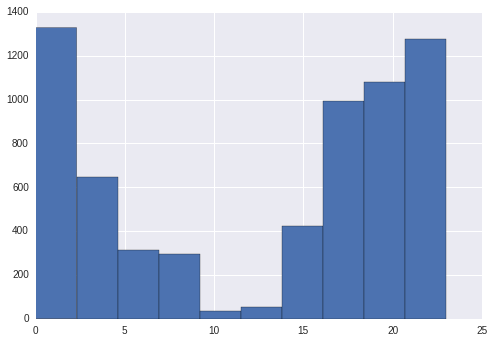

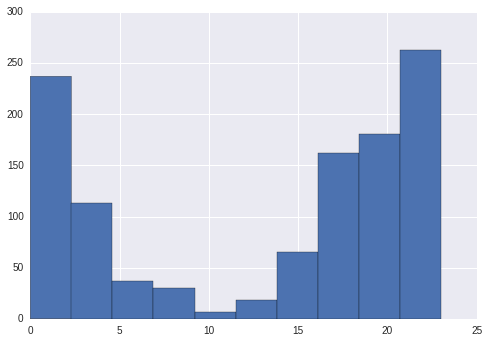

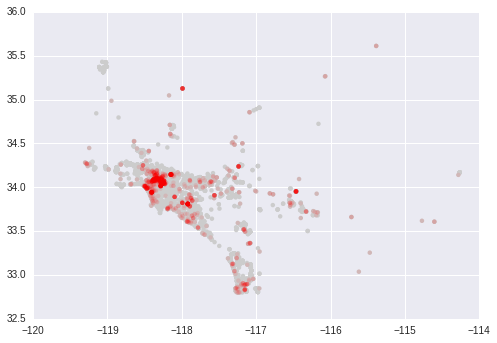

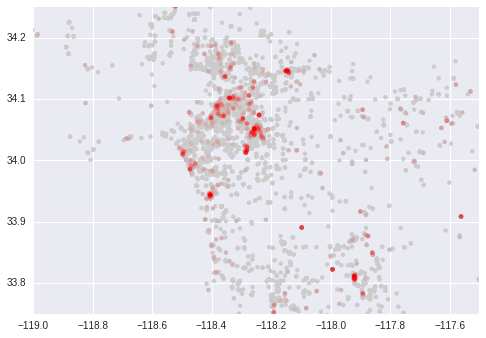

In [19]:
# print 5 random tweets from "in" and "out" groups
with con.cursor() as cur:
    cur.execute("SELECT tweet_id, text, user_id, tokens FROM tweets")
    tweets_df = pd.DataFrame(cur.fetchall(), columns=[c[0] for c in cur.description])
la_tourist_tweets = geotags_la[geotags_la.in_la_user==False].merge(tweets_df, on='tweet_id')
la_native_tweets = geotags_la[geotags_la.in_la_user==True].merge(tweets_df, on='tweet_id')
import datetime
geotags_la['time_of_day'] =  geotags_la.created_at.map(lambda x: x.hour)


plt.figure(1)
geotags_la[geotags_la.in_la_user].time_of_day.hist()
plt.figure(2)
geotags_la[geotags_la.in_la_user==False].time_of_day.hist()

# map of LA tweets/ tourist not
plt.figure(3)
plt.scatter(x=geotags_la.tweet_long, y=geotags_la.tweet_lat, c="#cccccc", 
            edgecolor='None')
plt.scatter(x=geotags_la[geotags_la.in_la_user==False].tweet_long, y=geotags_la[geotags_la.in_la_user==False].tweet_lat, c=(1.0,0.0,0.0,0.1), 
            edgecolor='None')
plt.figure(4)
plt.scatter(x=geotags_la.tweet_long, y=geotags_la.tweet_lat, c="#cccccc", 
            edgecolor='None')
plt.scatter(x=geotags_la[geotags_la.in_la_user==False].tweet_long, y=geotags_la[geotags_la.in_la_user==False].tweet_lat, c=(1.0,0.0,0.0,0.1), 
            edgecolor='None')
plt.xlim([-119,-117.5])
plt.ylim([33.75,34.25])
#print la_tourist_tweets.columns

In [16]:
import random
random.seed(505)

print la_tourist_tweets.loc[random.sample(la_tourist_tweets.index, 5)].text.values
print la_native_tweets.loc[random.sample(la_native_tweets.index, 5)].text.values

['@business Which, he fails to mention, he understands too well.'
 'The #hell that is usually the #I405 is actually not bad today... But it could do with being #sunny @\xe2\x80\xa6 https://t.co/5O80DWHwzm'
 'The most content girl in the world right now... #sleepingdogslie #shibainu #happydog\xe2\x80\xa6 https://t.co/srjxnjHKW0'
 '.@doctornorths cast playing #nodiggity at @sensorsexpo. #sensors15 #3dprinting cc: studiofathom @\xe2\x80\xa6 https://t.co/l2XQh4aI7G'
 'Im at City of San Bernardino - @sbcitygov in San Bernardino, CA https://t.co/TXJRPDDfRx']
[ 'Dylans graduation from 5th grade! Congrats bob_r_b We love you!! Xo @ Sherman Oaks Elementary Charter https://t.co/iWkJuHtsWe'
 '@DrosephStalin1 I have to start focusing my mental abilities....'
 '@yung_biskit ya right chu luv et!! ur my amehiken gehl!!'
 'If I were a tree, I would have roots like these. #octopus #roots #tree #botanicalgarden\xe2\x80\xa6 https://t.co/3nRRCR3g3I'
 'Were 8000 and something feet up. Took the aerial tram 

In [17]:
# get relative term frequency differences
#print la_tourist_tweets[la_tourist_tweets.text.map(lambda x: x.find("EXQUISITAMENTE") != -1)]
#print la_tourist_tweets[ ]

# top count items, full corpus
la_insider_corpus = u'\n'.join(la_native_tweets.tokens.dropna().map(lambda x: x.decode('utf-8')))
la_tourist_corpus = u'\n'.join(la_tourist_tweets.tokens.dropna().map(lambda x: x.decode('utf-8')))
la_corpus = la_insider_corpus + "\n" + la_tourist_corpus
#print la_tourist_corpus
from collections import Counter
import pprint

la_corpus_counts = dict(Counter(normalizer(la_corpus).split()).most_common(1000))
#print la_corpus_counts
la_insider_counts = Counter(normalizer(la_insider_corpus).split())
la_insider_counts = { x :  la_insider_counts[x] for x in la_corpus_counts.iterkeys() }
la_tourist_counts = Counter(normalizer(la_tourist_corpus).split())
la_tourist_counts = { x :  la_tourist_counts[x] for x in la_corpus_counts.iterkeys() }
logfreqs_df = pd.DataFrame(pd.concat([pd.Series(la_insider_counts, name="insider"), 
                              pd.Series(la_tourist_counts, name="tourist")], axis = 1))

logfreqs_df2 = logfreqs_df.apply(lambda x: pd.Series.rank(x, ascending=False))
logfreqs_df2.columns = ['insider_rank','tourist_rank']
logranks_df = logfreqs_df2.apply(np.log)
logranks_df.columns = ['insider_log_rank','tourist_log_rank']
logfreqs_df = pd.concat([logfreqs_df, logfreqs_df2, logranks_df], axis = 1)
logfreqs_df['logfreq_diff'] = logfreqs_df.apply(lambda x: x.insider_log_rank - x.tourist_log_rank, axis = 1)


In [18]:
logfreqs_df[(logfreqs_df.insider_rank < 160) & (logfreqs_df.logfreq_diff.map(np.abs) > 0.5)].sort('logfreq_diff', ascending = False)
logfreqs_df[logfreqs_df.insider_rank > 60].sort('insider_log_rank')

,insider,tourist,insider_rank,tourist_rank,insider_log_rank,tourist_log_rank,logfreq_diff
!!,173,35,60.5,46.0,4.102643,3.828641,0.274002
when,173,14,60.5,116.0,4.102643,4.753590,-0.650947
get,172,30,62.0,55.0,4.127134,4.007333,0.119801
one,168,25,63.0,62.5,4.143135,4.135167,0.007968
time,162,35,64.0,46.0,4.158883,3.828641,0.330242
what,159,17,65.0,94.0,4.174387,4.543295,-0.368908
good,146,18,66.0,86.5,4.189655,4.460144,-0.270490
dont,143,16,67.0,100.0,4.204693,4.605170,-0.400478
now,137,16,68.0,100.0,4.219508,4.605170,-0.385662
if,135,15,70.0,107.5,4.248495,4.677491,-0.428996


In [ ]:
# 1- and 2-gram lg models of "tourist" and "LA person" (w/ 10% holdout)
import random
random.seed(888)

native_tw = la_native_tweets.tokens.dropna().map(lambda x: x.decode('utf-8'))
tour_tw = la_tourist_tweets.tokens.dropna().map(lambda x: x.decode('utf-8'))

native_tw_corpus = [t for tw in native_tw for t in map(normalizer,tw.split()) ]
tour_tw_corpus = [t for tw in tour_tw for t in map(normalizer,tw.split()) ]

#import gensim
#from gensim.models import Phrases
#bigrams = Phrases(native_tw_corpus)
#dir(bigrams)

from nltk.util import ngrams
bigrams = list(ngrams(native_tw_corpus, 2))
counts = {}
for b in bigrams:
    counts[b] = counts.get(b, 0) + 1
#print u'\n'.join([ u' '.join(x) for x in counts.keys() if counts[x] > 30 ])
native_bigrams = bigrams
native_counts = counts

bigrams = list(ngrams(tour_tw_corpus, 2))
counts = {}
for b in bigrams:
    counts[b] = counts.get(b, 0) + 1
print u'\n'.join([ u' '.join(x) for x in counts.keys() if counts[x] > 30 ])
tour_bigrams = bigrams
tour_counts = counts

pd.DataFrame(native_counts)

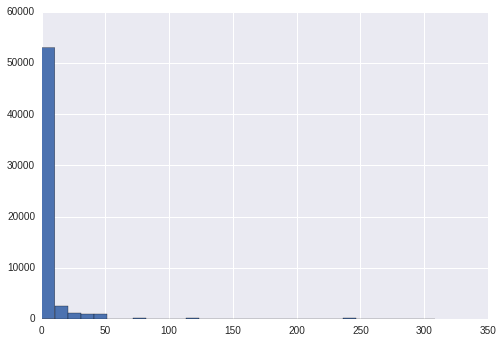

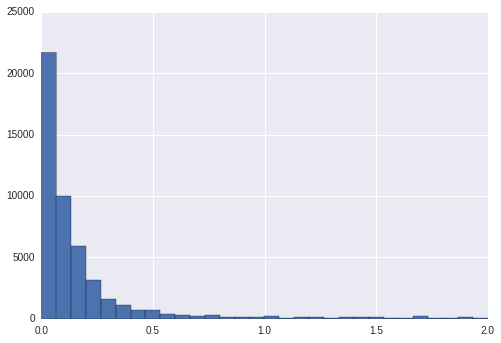

In [297]:
#print geotags.ix[np.argmax(geotags['tweet_distance'])]
#((geotags.user_lat - geotags.tweet_lat) ** 2).describe()
plt.figure(1)
geotags.tweet_distance.hist(bins=30)
plt.figure(2)
geotags[geotags.tweet_distance < 2].tweet_distance.hist(bins=30)


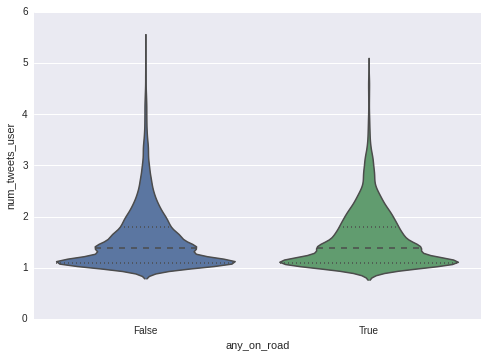

In [301]:
# compare number of tweets between on/off road
tweet_freqs = geotags[(geotags['num_tweets_user'] >= 3)][['user_id','num_tweets_user','any_on_road']]. \
    drop_duplicates()
#plt.axis([None, None, 0,5])

seaborn.violinplot(tweet_freqs.num_tweets_user.map(np.log), groupby=tweet_freqs.any_on_road)

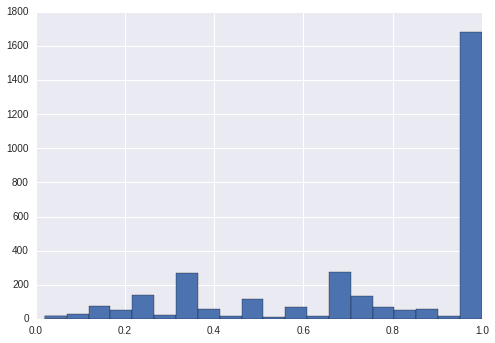

In [302]:
# for users who have 3+ tweets and any on road, 0-1 distribution of proportion of tweets on road?
geotags[(geotags['num_tweets_user'] >= 3) & (geotags.any_on_road > 0)]. \
    groupby('user_id').apply(
    lambda x: float(x.num_on_road.sum()) / float(x.num_tweets_user.sum())).hist(bins=20)

In [303]:
# do logistic regression on glove features
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing as skpre
import sklearn.cross_validation as skcv
import sklearn.metrics

In [304]:
num_features = 25
first_glove = "glove_0"
last_glove = "glove_{}".format(num_features - 1)

with con.cursor() as cur:
    cur.execute("SELECT tweet_id, " +
               ', '.join(["glove_{}".format(x) for x in range(0,num_features)]) +
               " FROM tweets WHERE glove_0 is not NULL")
    glove_mat = pd.DataFrame(cur.fetchall(), columns=[col[0] for col in cur.description])
glove_df = glove_mat.merge(geotags[['tweet_id', 'on_road']])
print glove_df.shape

(56445, 27)


In [305]:
import sklearn.metrics

print glove_df.columns
train, test = skcv.train_test_split(glove_df.dropna())
train = pd.DataFrame(train, columns = glove_df.columns)
test = pd.DataFrame(test, columns = glove_df.columns)


gscaler = skpre.StandardScaler()
gscaler.fit(train.loc[:,first_glove:last_glove])
train_scaled = gscaler.transform(train.loc[:,first_glove:last_glove])
test_scaled = gscaler.transform(test.loc[:,first_glove:last_glove])


response = train.on_road
predictors = train_scaled

logmodel = LogisticRegression()
model_results = logmodel.fit(train_scaled,response)

predictions = model_results.predict(test_scaled)
print sklearn.metrics.classification_report(test.on_road.astype(int), 
                                                pd.Series(predictions, index=test.index).astype(int))

from sklearn import svm
svmachine = svm.SVC(class_weight='auto')
model_results = svmachine.fit(train_scaled,response)

predictions = model_results.predict(test_scaled)
print sklearn.metrics.classification_report(test.on_road.astype(int), 
                                                pd.Series(predictions, index=test.index).astype(int))



Index([u'tweet_id', u'glove_0', u'glove_1', u'glove_2', u'glove_3', u'glove_4', u'glove_5', u'glove_6', u'glove_7', u'glove_8', u'glove_9', u'glove_10', u'glove_11', u'glove_12', u'glove_13', u'glove_14', u'glove_15', u'glove_16', u'glove_17', u'glove_18', u'glove_19', u'glove_20', u'glove_21', u'glove_22', u'glove_23', u'glove_24', u'on_road'], dtype='object')
             precision    recall  f1-score   support

          0       0.76      0.99      0.86     10669
          1       0.61      0.04      0.08      3443

avg / total       0.73      0.76      0.67     14112



/home/patrick/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:332: UserWarning: StandardScaler assumes floating point values as input, got object
  "got %s" % (estimator, X.dtype))


KeyboardInterrupt: 

In [ ]:
#Get topic feature matrix
num_topics = 10
first_topic = "topic_0"
last_topic = "topic_{}".format(num_topics - 1)
with con.cursor() as cur:
    cur.execute("SELECT user_id, " +
               ', '.join(["topic_{}".format(x) for x in range(0,num_topics)]) +
               " FROM users WHERE topic_0 is not NULL")
    topic_matrix = pd.DataFrame(cur.fetchall(), columns = ["user_id"] + 
                           ["topic_{}".format(x) for x in range(0,num_topics)])
geotopics = topic_matrix.merge(geotags[['user_id','any_on_road','num_tweets_user']].drop_duplicates(), 
                               on='user_id', how='left') 



In [ ]:
print geotopics.dropna().any_on_road.shape[0]
print geotopics.dropna().any_on_road.sum()



In [ ]:
# More features
with con.cursor() as cur:
    cur.execute("SELECT tweet_id, user_id, text,tokens FROM tweets")
    twdf = pd.DataFrame(cur.fetchall(), columns=[c[0] for c in cur.description])

import re
twdf_reduced = twdf[twdf.user_id.isin(geotopics.user_id)]
twdf_reduced['be_ing'] = twdf_reduced.text.map(lambda x: re.search(r"\b(be|im|am|are|is)\s[a-z]+ing\b", 
                                                                   x,re.UNICODE | re.IGNORECASE) is not None)
twdf_reduced['go'] = twdf_reduced.text.map(lambda x: re.search(r"\b(go|going|went)\b", 
                                                                   x,re.UNICODE | re.IGNORECASE) is not None)
twdf_reduced['today'] = twdf_reduced.text.map(lambda x: re.search(r"\b(today|tomorrow)\b", 
                                                                   x,re.UNICODE | re.IGNORECASE) is not None)

In [ ]:
twdf_reduced['urlfinal'] = twdf_reduced.text.map(lambda x: re.search(r"\bhttps?\:\/\/[^\s]+$", 
                                                                   x,re.UNICODE | re.IGNORECASE) is not None)
user_newfeats = twdf_reduced.groupby('user_id').sum()

user_newfeats.columns

In [ ]:
# Merge topics and new features
geotopics_new = geotopics.dropna().merge(user_newfeats, left_on='user_id', right_index=True)
#normalize
geotopics_new[[u'be_ing', u'go', u'today', u'urlfinal']] = geotopics_new[[u'be_ing', u'go', u'today', u'urlfinal']].apply(lambda x: x / geotopics_new.num_tweets_user)


print geotopics.columns
geotopics_new.set_index('user_id')
response = geotopics_new.dropna()['any_on_road']
predictors = geotopics_new.dropna().drop(['user_id', 'num_tweets_user','any_on_road'], axis=1)
print predictors.columns

#polynomial features
from sklearn.preprocessing import PolynomialFeatures
polyf =  PolynomialFeatures(degree = 2)
new_predictors = polyf.fit_transform(predictors.values)
print new_predictors

In [ ]:
new_predictors.shape

In [ ]:
import pickle

train, test = skcv.train_test_split(np.concatenate([pd.DataFrame(response), predictors], axis = 1), random_state = 888)
train = pd.DataFrame(train, columns = ["any_on_road"] + predictors.columns.tolist())
test = pd.DataFrame(test, columns = ["any_on_road"] + predictors.columns.tolist())

scaler = skpre.StandardScaler()
scaler.fit(train[:,1:])
train_scaled = scaler.transform(train[:,1:])
test_scaled = scaler.transform(test[:,1:])
#predictors_scaled = skpre.scale(predictors)
#test

pickle.dump(scaler, file("../scaler.pickle","w"))

In [ ]:
print train.shape
print test.shape

In [ ]:

# Logistic Regression
logmodel = LogisticRegression()
model_results = logmodel.fit(train_scaled,train.any_on_road)

predictions = model_results.predict(test_scaled)
print float((test.any_on_road == False).sum())/float(test.shape[0])
print float((predictions == test.any_on_road).sum())/float(test.shape[0])
print sklearn.metrics.classification_report(test.any_on_road.astype(int), 
                                                pd.Series(predictions, index=test.index).astype(int))


In [ ]:
# try SVM
from sklearn import svm
svmachine = svm.SVC(class_weight='auto')
model_results = svmachine.fit(train_scaled,train[:,0])

predictions = model_results.predict(train_scaled)
print "Baseline:", float((test[:,0]== False).sum())/float(test.shape[0])
print "Training accuracy:", float((predictions == train[:,0]).sum())/float(train.shape[0])

predictions = model_results.predict(test_scaled)
print "Testing accuracy:", float((predictions == test[:,0]).sum())/float(test.shape[0])

In [ ]:
import sklearn.metrics

print sklearn.metrics.classification_report(test[:,0].astype(int), 
                                                predictions.astype(int))

# save model
import pickle
pickle.dump(svmachine, file("../svm.pickle", "w"))

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
ranfor = RandomForestClassifier(n_estimators=500)

model_results = ranfor.fit(train_scaled,train.any_on_road)
predictions = model_results.predict(test_scaled)
print float((test.any_on_road == False).sum())/float(test.shape[0])
print float((predictions == test.any_on_road).sum())/float(test.shape[0])
import sklearn.metrics

sklearn.metrics.precision_recall_fscore_support(test.any_on_road.astype(int), 
                                                pd.Series(predictions, index=test.index).astype(int))

print sklearn.metrics.classification_report(test.any_on_road.astype(int), 
                                                pd.Series(predictions, index=test.index).astype(int))
